# Import packages

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
torch.manual_seed(0)
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# Functions

In [ ]:
def absmax(x):
  """
  This function quantize/dequantize each tensor's weights to an INT8 tensor
  using absmax quantization.
  """
  scale = 127/torch.max(torch.abs(x))
  x_quant = (scale * x).round()
  x_dequant = x_quant / scale

  return x_quant, x_dequant

In [ ]:
def zeropoint(x):
  """
  This function quantize/dequantize each tensor's weights to an INT8 tensor
  using zeropoint quantization.
  """
  scale = 255/(torch.max(x) - torch.min(x))
  zeropoint = -(torch.min(x)*scale).round() - 127

  x_quant = (scale * x).round() + zeropoint
  x_dequant = (x_quant - zeropoint) / scale

  return x_quant, x_dequant

# Main code

In this section, we are going to implement two famous quantization techniques : a symmetric one with absolute maximum (absmax) and an asymmetric one with zero point quantization. They both consist in mapping an FP32 tensor (the original weight) to an INT8 tensor X_quant (quantized weights)


Before walking through the details of those techniques, we are going to load a gpt2 model.

#### Load the model

In [ ]:
# Set device to CPU for now
device = 'cpu'

# Load model and tokenizer
model_id = 'gpt2'
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)

#### GTP2's architecture and size :

In [ ]:
# Print model size
print(f"Model size: {model.get_memory_footprint():,} bytes")


# Print model size in GB
print(f"\nModel size: {round(model.get_memory_footprint()/10**9)} GB")

Model size: 510,342,192 bytes

Model size: 1 GB


As shown below, the model is composed of 12 GPT2Blacks in which we have attention layers.

In [ ]:
print("GPT2's architecture : \n", model)

GPT2's architecture : 
 GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [ ]:
print("GPT2's transformer architecture : \n", model.transformer.h)

GPT2's transformer architecture : 
 ModuleList(
  (0-11): 12 x GPT2Block(
    (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (attn): GPT2SdpaAttention(
      (c_attn): Conv1D()
      (c_proj): Conv1D()
      (attn_dropout): Dropout(p=0.1, inplace=False)
      (resid_dropout): Dropout(p=0.1, inplace=False)
    )
    (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): GPT2MLP(
      (c_fc): Conv1D()
      (c_proj): Conv1D()
      (act): NewGELUActivation()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)


In [ ]:
print("GPT2's first transformer's architecture : \n", model.transformer.h[0])

GPT2's first transformer's architecture : 
 GPT2Block(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): GPT2SdpaAttention(
    (c_attn): Conv1D()
    (c_proj): Conv1D()
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (resid_dropout): Dropout(p=0.1, inplace=False)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): GPT2MLP(
    (c_fc): Conv1D()
    (c_proj): Conv1D()
    (act): NewGELUActivation()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)


- Quantize the first layer of GPT2

In [ ]:
# Extract weights of the first layer
weights = model.transformer.h[0].attn.c_attn.weight.data
print("GPT2's first transformer's wieghts : \n",weights)

GPT2's first transformer's wieghts : 
 tensor([[-0.4738, -0.2614, -0.0978,  ...,  0.0513, -0.0584,  0.0250],
        [ 0.0874,  0.1473,  0.2387,  ..., -0.0525, -0.0113, -0.0156],
        [ 0.0039,  0.0695,  0.3668,  ...,  0.1143,  0.0363, -0.0318],
        ...,
        [-0.2592, -0.0164,  0.1991,  ...,  0.0095, -0.0516,  0.0319],
        [ 0.1517,  0.2170,  0.1043,  ...,  0.0293, -0.0429, -0.0475],
        [-0.4100, -0.1924, -0.2400,  ..., -0.0046,  0.0070,  0.0198]])


In [ ]:
# quantize weights using absmax quantization
print("Quantization weights using absmax:")
abs_quant_weights, _ = absmax(weights)
print(abs_quant_weights)

Quantization weights using absmax:
tensor([[-21., -12.,  -4.,  ...,   2.,  -3.,   1.],
        [  4.,   7.,  11.,  ...,  -2.,  -1.,  -1.],
        [  0.,   3.,  16.,  ...,   5.,   2.,  -1.],
        ...,
        [-12.,  -1.,   9.,  ...,   0.,  -2.,   1.],
        [  7.,  10.,   5.,  ...,   1.,  -2.,  -2.],
        [-18.,  -9., -11.,  ...,  -0.,   0.,   1.]])


In [ ]:
# quantize weights using zero point quantization
print("Quantization weights using zero point :")
zero_point_quantization, _ = zeropoint(weights)
print(zero_point_quantization)

Quantization weights using zero point :
tensor([[-19., -10.,  -2.,  ...,   4.,  -1.,   3.],
        [  6.,   9.,  13.,  ...,   0.,   1.,   1.],
        [  2.,   5.,  19.,  ...,   7.,   4.,   1.],
        ...,
        [-10.,   1.,  11.,  ...,   2.,   0.,   3.],
        [  9.,  12.,   7.,  ...,   3.,   0.,   0.],
        [-17.,  -7.,  -9.,  ...,   2.,   2.,   3.]])


In [ ]:
# get the original weights
weights = [param.data.clone() for param in model.parameters()]

# Create a copy of the model
model_abs = deepcopy(model)

abs_weights = []
for param in model_abs.parameters():
  abs_quant_weights, abs_dequant_weights = absmax(param.data)
  param.data = abs_dequant_weights
  abs_weights.append(abs_dequant_weights)
  #print(" --- : ", param.data)



# Create a copy of the model
model_zeropoint = deepcopy(model)

zeropoint_weights = []
for param in model_zeropoint.parameters():
  zp_quant_weights, zp_dequant_weights = zeropoint(param.data)
  param.data = zp_dequant_weights
  zeropoint_weights.append(zp_dequant_weights)
  #print(" --- : ", param.data)

In [ ]:
# flatten orginal weights
weights = np.concatenate([tensor.cpu().numpy().flatten() for tensor in weights])
# flatten absmax weights
abs_weights = np.concatenate([tensor.cpu().numpy().flatten() for tensor in abs_weights])
# flatten zeropoint weights
zeropoint_weights = np.concatenate([tensor.cpu().numpy().flatten() for tensor in zeropoint_weights])

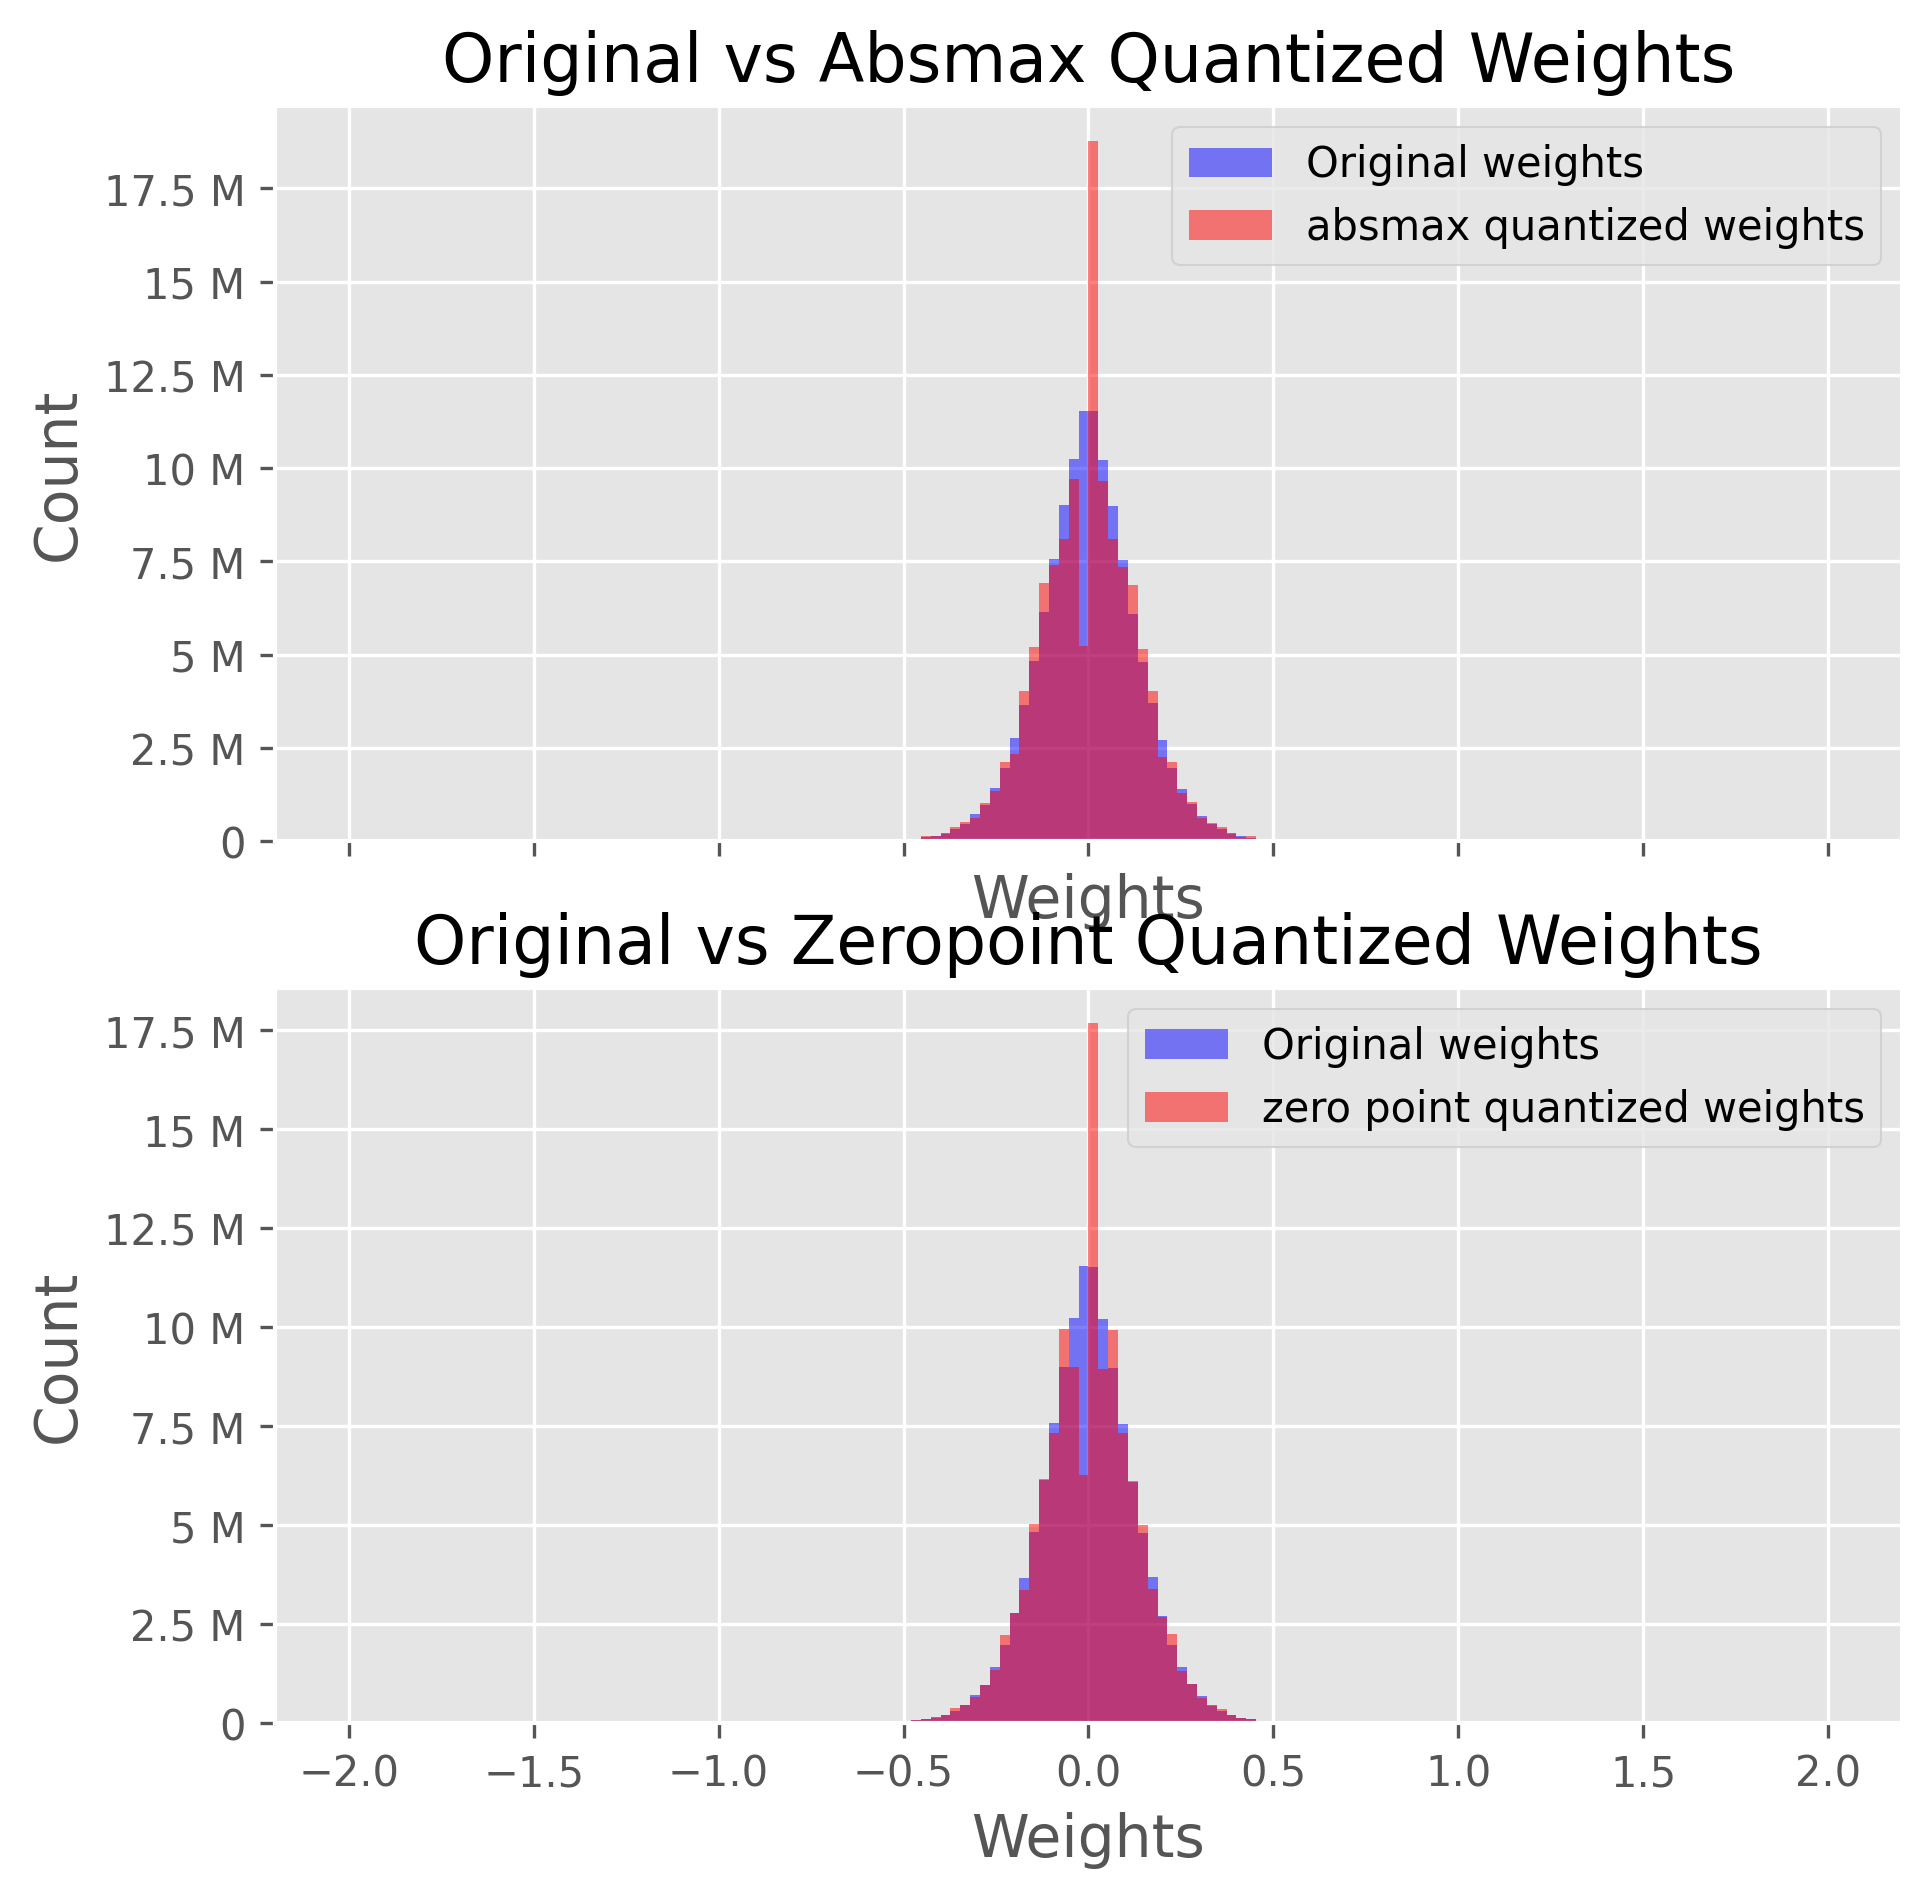

In [ ]:
# plot the distribution of the original weights, absmax quantized weights and zeropoint quantized weights

# use ggplot as a background style
plt.style.use('ggplot')

fig, axs = plt.subplots(2, figsize = (7, 7 ), dpi=300, sharex=True)

axs[0].hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
axs[0].hist(abs_weights, bins=150, alpha=0.5, label='absmax quantized weights', color='red', range=(-2, 2))

axs[1].hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
axs[1].hist(zeropoint_weights, bins=150, alpha=0.5, label='zero point quantized weights', color='red', range=(-2, 2))


# Add legend
axs[0].legend()
axs[1].legend()

# Add title and labels
axs[0].set_title('Original vs Absmax Quantized Weights', fontsize=16)
axs[1].set_title('Original vs Zeropoint Quantized Weights', fontsize=16)

for ax in axs:
    ax.set_xlabel('Weights', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.yaxis.set_major_formatter(ticker.EngFormatter())

#### Generate text using original, absmax quantized and zeropoint quantized models :

In [ ]:
def generate_data(input_text, model, max_length):
    """
    This function generates text using gpt2 model or its
    quantized versions.
    It takes into parameter :
        - input_text : input sentence
        - model : model to be used (gt2 or its quantized versions)
        - max_length : an upper bound that is used for truncation when necessary
    """
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    output = model.generate(inputs=input_ids,
                        max_length=max_length,
                        do_sample=True,
                        top_k=30,
                        pad_token_id=tokenizer.eos_token_id,
                        attention_mask=input_ids.new_ones(input_ids.shape))
    result = tokenizer.decode(output[0], skip_special_tokens=True)
    return result

In [ ]:
# input text
input_text = "AI is impressive"

# max length
max_length = 80

In [ ]:
# text generated with original model
original_text = generate_data(input_text, model, max_length)

# text generated with absmax quantized model
absmax_text = generate_data(input_text, model_abs, max_length)

# text generated with zeropoint quantized model
zeropoint_text = generate_data(input_text, model_zeropoint, max_length)

print(" Text generated with original model : \n", original_text)
print("-"*40)
print(" Text generated with absmax quantized model : \n", absmax_text)
print("-"*40)
print(" Text generated with zeropoint quantized model : \n", zeropoint_text)

 Text generated with original model : 
 AI is impressive but, at the same time, very little research seems to have been done to quantify the effectiveness of antidepressants. One study that appeared in the journal "Ajinomoto: A Comprehensive Review of the Literature" used a random-effects model to examine the effectiveness of one study of antidepressants with antiepileptic efficacy in depressed individuals. A combination of the randomized-effects and placebo
----------------------------------------
 Text generated with absmax quantized model : 
 AI is impressive. If you've read The Martian you know you don't like it. If you've read The Martian you don't want to buy a copy. You just wish you could live it. I can see you buying it. It's fantastic! Now, it's not for sale. It's a replica. That's right. It's a replica that will be sold out in the
----------------------------------------
 Text generated with zeropoint quantized model : 
 AI is impressive for a company that is focused on crea